# Import libraries

In [180]:
# import standard libraires
from joblib import dump, load
import os.path
# import third-part libraries
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression, RFECV, RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import tree
# import local libraries

# Import data

In [181]:
# import data ready from eda
all_data = pd.read_csv('movies_metadata_eda.csv')

In [182]:
# drop duplicates in id columns
all_data = all_data.drop_duplicates('id', ignore_index = True)
# set index to id
all_data = all_data.set_index('id', drop = False)

In [183]:
data = all_data.drop(columns = ['id', 'original_title'])

In [184]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42639 entries, 862 to 461257
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   adult                        42639 non-null  int64  
 1   budget                       42639 non-null  float64
 2   popularity                   42639 non-null  float64
 3   revenue                      42639 non-null  float64
 4   runtime                      42639 non-null  float64
 5   video                        42639 non-null  int64  
 6   vote_average                 42639 non-null  float64
 7   vote_count                   42639 non-null  float64
 8   release_year                 42639 non-null  int64  
 9   release_month                42639 non-null  int64  
 10  roi                          42639 non-null  float64
 11  revenue_norm_max             42639 non-null  float64
 12  year_revenue_max             42639 non-null  float64
 13  budget_norm_m

# Feature selection

In [185]:
# separate exo and indogeneous variables, We choose to predict popularity
# this means we need to drop all columns that contain the revenue and votes 
data = data.astype(np.float64)
target_label = 'popularity' #'revenue_norm_mean'
data = data.drop(columns = [
                            'revenue', 
                            'vote_average', 
                            'vote_count', 
                            'roi',
                            'revenue_norm_max', 
                            'revenue_norm_mean',
                           ]
                ) # ['revenue', 'roi', 'revenue_norm_max']
X, y = data.drop(columns = target_label), data[[target_label]]
y = y[target_label]

# normalize inputs
scaler = MinMaxScaler()
X_trans = scaler.fit_transform(X)
X_trans = pd.DataFrame(data = X_trans, columns = X.columns, index = X.index)

# keep a eye on number of accepted features
feature_score = pd.DataFrame(index = X.columns)

## Pearson correlation

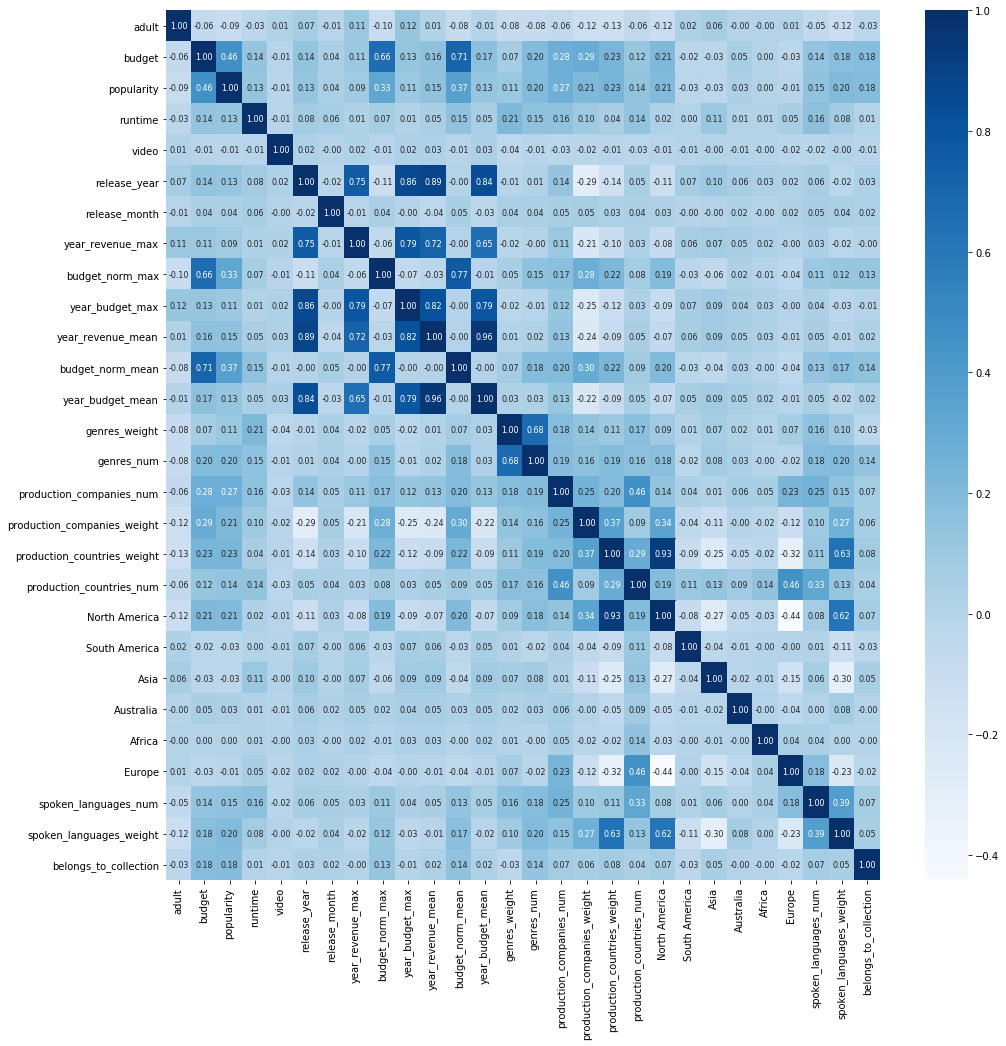

In [22]:
# since all columns are numeric, we can compute the pearsoncorrelation 
fig, ax = plt.subplots(figsize = (16, 16))
pearson = data.corr()
sns.heatmap(pearson, annot = True, cmap = plt.cm.Blues, annot_kws = {'size': 8}, fmt = '.2f')

If we look under revenue_norm_mean, we see that the following columns have a pearson correlation above apprimately 0.20

In [23]:
feature_score['pearson'] = np.nan
feature_score['pearson'] = pearson[target_label].apply(lambda x: True if x > 0.19 else False)
num_feat = feature_score['pearson'].sum()
print(feature_score)
print(num_feat)

                             pearson
adult                          False
budget                          True
runtime                        False
video                          False
release_year                   False
release_month                  False
year_revenue_max               False
budget_norm_max                 True
year_budget_max                False
year_revenue_mean              False
budget_norm_mean                True
year_budget_mean               False
genres_weight                  False
genres_num                      True
production_companies_num        True
production_companies_weight     True
production_countries_weight     True
production_countries_num       False
North America                   True
South America                  False
Asia                           False
Australia                      False
Africa                         False
Europe                         False
spoken_languages_num           False
spoken_languages_weight         True
b

## F-value selection

In [24]:
kbest_selector = SelectKBest(score_func = f_regression, k = num_feat)
kbest_selector = kbest_selector.fit(X_trans, y)
kbest = kbest_selector.get_support()
# add to feature_score
feature_score['f_value'] = np.nan
feature_score['f_value'] = kbest

## RFE selection

In [25]:
temp_est = SVR(kernel = 'linear')
rfe = RFE(temp_est, n_features_to_select = 7, step = 1)
rfe = rfe.fit(X_trans, y)
rfe_best = rfe.get_support()

In [26]:
feature_score['rfe'] = np.nan
feature_score['rfe'] = rfe_best

In [27]:
feature_score['total_score'] = feature_score[['pearson', 'f_value', 'rfe']].sum(axis = 1)
feature_score

,pearson,f_value,rfe,total_score
adult,False,False,False,0
budget,True,True,True,3
runtime,False,False,True,1
video,False,False,False,0
release_year,False,False,False,0
release_month,False,False,False,0
year_revenue_max,False,False,False,0
budget_norm_max,True,True,False,2
year_budget_max,False,False,False,0
year_revenue_mean,False,False,False,0


## Best features

In [28]:
best_feature = feature_score.sort_values(by = 'total_score', ascending = False)[:num_feat]
best_feature

,pearson,f_value,rfe,total_score
genres_num,True,True,True,3
budget_norm_mean,True,True,True,3
production_companies_num,True,True,True,3
budget,True,True,True,3
spoken_languages_weight,True,True,False,2
North America,True,True,False,2
production_countries_weight,True,True,False,2
production_companies_weight,True,True,False,2
budget_norm_max,True,True,False,2


## Filter X of best features

In [188]:
X_trans_best = X_trans[best_feature.index.values]
X_trans_best

,genres_num,budget_norm_mean,production_companies_num,budget,spoken_languages_weight,North America,production_countries_weight,production_companies_weight,budget_norm_max
id,,,,,,,,,
862,0.375,0.034350,0.038462,0.078947,0.618512,1.0,0.588707,0.021104,0.171429
8844,0.375,0.074426,0.115385,0.171053,0.708454,1.0,0.588707,0.079951,0.371429
15602,0.250,0.000000,0.076923,0.000000,0.618512,1.0,0.588707,0.477273,0.000000
31357,0.375,0.018320,0.038462,0.042105,0.618512,1.0,0.588707,0.319805,0.091429
949,0.500,0.068701,0.115385,0.157895,0.669885,1.0,0.588707,0.518263,0.342857
...,...,...,...,...,...,...,...,...,...
30840,0.375,0.000000,0.153846,0.000000,0.618512,1.0,0.814546,0.066153,0.000000
111109,0.125,0.000000,0.038462,0.000000,0.000000,0.0,0.002353,0.000406,0.000000
67758,0.375,0.000000,0.038462,0.000000,0.618512,1.0,0.588707,0.001218,0.000000


In [189]:
X_trans_best.to_csv('movies_metadata_eda_x_trans_best.csv', index = True)

# SVR with CV

In [192]:
X_trans_best = pd.read_csv('movies_metadata_eda_x_trans_best.csv', index_col = 0)

In [193]:
# seperate x data into training and test sets, we take 30% test and 70% train
X_train, X_test, y_train, y_test = train_test_split(X_trans_best, y, test_size = 0.3, random_state = 45) #45

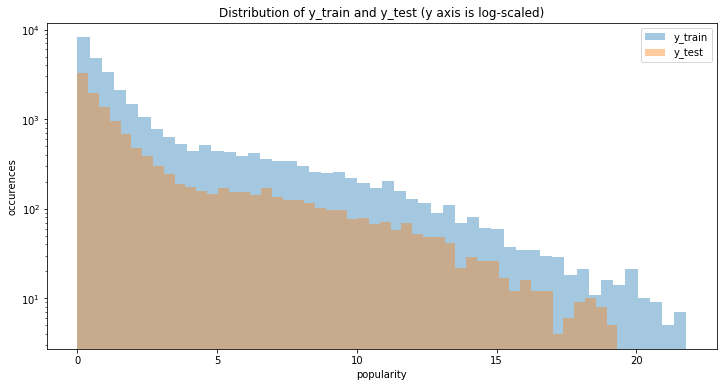

In [194]:
# check if y_train and y_test are equally distributed
fig, ax = plt.subplots(figsize = (12, 6))
# remove outliers using z-score
to_plot_train = y_train[(np.abs(stats.zscore(y_train)) < 3)]
to_plot_test = y_test[(np.abs(stats.zscore(y_test)) < 3)]
g = sns.distplot(to_plot_train, kde = False, ax = ax, label = 'y_train')
g.set_yscale('log')
sns.distplot(to_plot_test, kde = False, ax = ax, label = 'y_test')
g.set_ylabel('occurences')
g.set_title('Distribution of y_train and y_test (y axis is log-scaled)')
g.legend()

In [35]:
# define grid of hyperparameters for SVR
param_grid = {'C': [10, 100, 1000], 
              'gamma': [0.1, 0.01, 0.001],
              'kernel': ['rbf']}
scores = ['r2']
regressors = {k: None for k in scores}
results = {k: None for k in scores}

In [36]:
filename_regressors = 'svrcv_regressors_popularity_3.joblib'
filename_results = 'svrcv_results_popularity_3.joblib'

if not os.path.isfile(filename_regressors) and not os.path.isfile(filename_results):

    # perform grid search for all score
    for s in scores:
        # create grid search for hyperparameters
        reg = GridSearchCV(SVR(), param_grid, scoring = s) # we use default 5-fold cross validation
        # fit
        reg.fit(X_train, y_train)
        # keep fitted regressor
        regressors[s] = reg
        # get score and parameters and create a dataframe of results
        means = reg.cv_results_['mean_test_score']
        params = reg.cv_results_['params']
        index = pd.MultiIndex.from_frame(pd.DataFrame(params))
        res = pd.DataFrame(data = means, index = index)
        # store results
        results[s] = res

    # save results in pickle file
    dump(regressors, filename_regressors)
    dump(results, filename_results)
    
else:
    
    regressors = load(filename_regressors)
    results = load(filename_results)

In [37]:
all_results = pd.DataFrame()
for k, _ in results.items():
    if k == 'r2':
        results[k] = results[k].rename(columns = {0: k})
        all_results = pd.concat([all_results, results[k]], axis = 1)

In [38]:
for k, _ in regressors.items():
    print(k)
    print(regressors[k].best_params_)

r2
{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}


In [39]:
# take sum of scores and sort from best to worst score
#all_results['total_score'] = np.nan
#all_results['total_score'] = all_results[scores[0:1]].sum(axis = 1)
all_results = all_results.sort_values(by = 'r2', ascending = False)

In [40]:
all_results

r2
C    gamma kernel          
1000 0.100 rbf     0.280881
     0.010 rbf     0.273806
100  0.100 rbf     0.273427
10   0.100 rbf     0.269299
100  0.010 rbf     0.261917
1000 0.001 rbf     0.253820
10   0.010 rbf     0.226017
100  0.001 rbf     0.222085
10   0.001 rbf     0.142812

In [41]:
# new using trained estimators
regr_r2 = regressors['r2']
r2_score = regr_r2.score(X_test, y_test)
r2_score

0.2874656486807513

# Decision trees

In [42]:
param_grid = {'min_samples_split': [2, 5, 10, 50, 100, 500, 1000, 5000], 
              'max_depth': [10, 50, 100, 500, 1000, 5000, 10000],
              'min_samples_leaf': [1, 10, 50, 100, 500, 1000]
             }

reg_tree = GridSearchCV(DecisionTreeRegressor(), param_grid)
reg_tree = reg_tree.fit(X_train, y_train)

In [43]:
print(reg_tree.best_params_)
reg_tree.score(X_test, y_test)

{'max_depth': 10, 'min_samples_leaf': 100, 'min_samples_split': 2}


0.3382806085180253

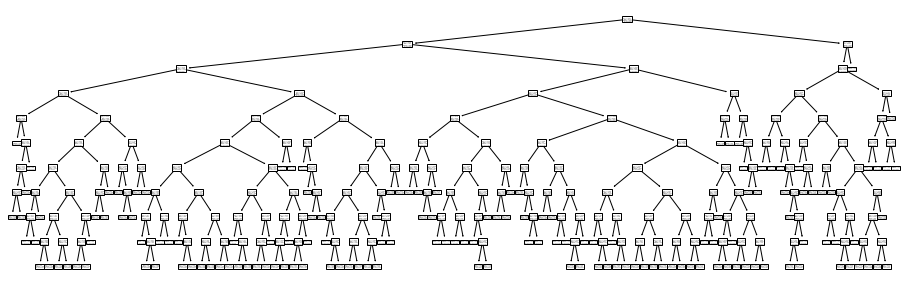

In [44]:
temp = reg_tree.best_estimator_
fig, ax = plt.subplots(figsize = (16, 5))
_ = tree.plot_tree(temp, ax = ax)

# Baggign on SVR

In [45]:
# use bagging
reg_bag = BaggingRegressor(SVR(C = 1000, gamma = 0.1, kernel = 'rbf'), n_estimators = 100)
reg_bag = reg_bag.fit(X_train, y_train)

In [46]:
reg_bag.score(X_test, y_test)

0.2883158994716094

## BAgging on tree 

In [47]:
reg_bag_2 = BaggingRegressor(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 100, min_samples_split = 2
                                                  ), n_estimators = 100)
reg_bag_2 = reg_bag_2.fit(X_train, y_train)

In [48]:
reg_bag_2.score(X_test, y_test)

0.34005652314433565

# Results

In [286]:
X_test_sample = X_test.sample(n = len(X_test))

In [287]:
# get a sample of movies we know and don't know
known_movies = all_data.loc[X_test_sample.index,:]
known_movies = known_movies[known_movies['budget'] >= 1e8]
known_movies = known_movies[known_movies['revenue'] >= 9e8]

In [288]:
# get random unknwon movies
unknown_movies = all_data.loc[X_test.sample(n = len(known_movies), random_state = 23).index,:]

In [289]:
# stack known and unknown movies
sampled_movies = pd.concat([known_movies, unknown_movies], axis = 0)
col_select = ['original_title', 'popularity'] + list(best_feature.index)
sampled_movies = sampled_movies[col_select]

In [290]:
# get scaled movies selected
X_sample = X_test.loc[sampled_movies.index, :]

In [291]:
# get prediction of SVM
y_predict_sample_svm = regr_r2.predict(X_sample)

In [292]:
# get prediction of Decision trees
y_predict_sample_tre = reg_tree.predict(X_sample)

In [293]:
# put predictions in sampled movies
sampled_movies.insert(2, 'popularity (SVM)', y_predict_sample_svm)
sampled_movies.insert(3, 'popularity (Decision Tree)', y_predict_sample_tre)

In [294]:
sampled_movies

,original_title,popularity,popularity (SVM),popularity (Decision Tree),genres_num,budget_norm_mean,production_companies_num,budget,spoken_languages_weight,North America,production_countries_weight,production_companies_weight,budget_norm_max
id,,,,,,,,,,,,,
37724,Skyfall,20.309585,18.985019,28.702647,3,35.290383,1,200000000.0,0.544100,1,0.509461,0.006162,0.769231
271110,Captain America: Civil War,145.882135,15.162460,28.702647,3,36.002162,5,250000000.0,0.625303,1,0.426970,0.001070,1.000000
1865,Pirates of the Caribbean: On Stranger Tides,27.887720,23.237072,28.702647,3,61.373858,3,380000000.0,0.589291,1,0.426970,0.004373,1.000000
24428,The Avengers,89.887648,17.237857,28.702647,3,38.819421,2,220000000.0,0.544100,1,0.426970,0.014817,0.846154
1893,Star Wars: Episode I - The Phantom Menace,15.649091,12.691974,11.935994,3,12.912459,1,115000000.0,0.544100,1,0.426970,0.000428,0.676471
155,The Dark Knight,123.167259,15.732513,28.702647,4,28.415013,5,185000000.0,0.559042,1,0.509461,0.020031,0.822222
49026,The Dark Knight Rises,20.582580,17.652539,28.702647,4,44.112979,4,250000000.0,0.544100,1,0.426970,0.019144,0.961538
109445,Frozen,24.248243,16.901211,28.702647,3,26.327645,2,150000000.0,0.544100,1,0.426970,0.004235,0.588235
675,Harry Potter and the Order of the Phoenix,21.364300,16.308530,28.702647,4,23.066411,2,150000000.0,0.544100,1,0.509461,0.018211,0.500000


In [298]:
# get rocky and batman & robin
rocky = all_data[all_data['original_title'] == 'Rocky']
X_rocky = X_test.loc[rocky.index]
y_predict_svm_rocky = regr_r2.predict(X_rocky)
print(y_predict_svm_rocky)
y_predict_tre_rocky = reg_tree.predict(X_rocky)
print(y_predict_tre_rocky)
rocky

[2.08230086]
[6.03114997]


,id,original_title,adult,budget,popularity,revenue,runtime,video,vote_average,vote_count,...,production_countries_num,North America,South America,Asia,Australia,Africa,Europe,spoken_languages_num,spoken_languages_weight,belongs_to_collection
id,,,,,,,,,,,,,,,,,,,,,
1366,1366,Rocky,0,1000000.0,14.774066,117235147.0,119.0,0,7.5,1843.0,...,1,1,0,0,0,0,0,1,0.5441,1


In [299]:
# batman and robin
batman = all_data[all_data['original_title'] == 'Batman and Robin']
X_batman = X_test.loc[batman.index]
y_predict_svm_batman = regr_r2.predict(X_batman)
print(y_predict_svm_batman)
y_predict_tre_batman = reg_tree.predict(X_batman)
print(y_predict_tre_batman)
batman

,id,original_title,adult,budget,popularity,revenue,runtime,video,vote_average,vote_count,...,production_countries_num,North America,South America,Asia,Australia,Africa,Europe,spoken_languages_num,spoken_languages_weight,belongs_to_collection
id,,,,,,,,,,,,,,,,,,,,,
93560,93560,Batman and Robin,1,0.0,0.224261,0.0,263.0,0,6.2,5.0,...,0,0,0,0,0,0,0,1,0.5441,0
